## 1. Imports and Global Configuration
This section imports necessary libraries (SimPy, Pandas, Matplotlib, Tkinter) and defines global simulation parameters such as shift hours, arrival rates, and duration distributions.

In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import scrolledtext
import time
import scipy.stats as stats
import matplotlib.pyplot as plt


# 1. MODEL CONFIGURATION

# Simulation runs for 24 hours (1440 minutes)
SIM_TIME = 1440        # 24 Hours
WORK_START_TIME = 480  # 08:00 AM
WORK_END_TIME = 1080   # 06:00 PM 
CUTOFF_TIME = 960      # 04:00 PM (No new elective cases after this time)

# STATISTICAL SETTINGS
INTERARRIVAL_EMERGENCY = 180    # Average time between emergency arrivals (Exponential)
NUM_ELECTIVE_CASES = 12         # Target number of scheduled surgeries per day
BUFFER_TIME = 0                 # Gap between scheduled surgeries             

# DURATION DISTRIBUTIONS
# We use Log-Normal for surgeries because they vary significantly (long tail)
# Surgery time
MEAN_DURATIONS = {'Short': 60, 'Medium': 120, 'Long': 180}
TURNOVER_PARAMS = (15, 25, 35)   # Triangular distribution for cleaning (Min, Mode, Max)

ANIMATION_DELAY = 0.4    # Speed of the visual demo (Lower = Faster)


## 2. Helper Functions
Utility functions to generate random surgery durations (Log-Normal), turnover times (Triangular), and convert simulation minutes to a clock format (HH:MM).

In [4]:
# 2. HELPER FUNCTIONS

def get_surgery_duration():
    """
    Generates a random surgery duration using Log-Normal distribution.
    Why Log-Normal? Because surgery times are always positive and often skewed right.
    """
    s_type = random.choice(['Short', 'Medium', 'Long'])
    m = MEAN_DURATIONS[s_type]
    sigma = 0.5
    mu = np.log(m) - (sigma**2 / 2)
    return random.lognormvariate(mu, sigma)

def get_turnover_time():
    """
    Generates cleaning time using Triangular distribution (Min, Mode, Max).
    """
    return random.triangular(*TURNOVER_PARAMS)

def mins_to_clock(minutes):
    """
    Utility to convert simulation minutes (e.g., 480) to Clock format (08:00).
    """
    day_min = minutes % 1440
    h = int(day_min // 60)
    m = int(day_min % 60)
    return f"{h:02d}:{m:02d}"

## 3. Visualization Interface (GUI)
The `HospitalGUI` class handles the Tkinter window, drawing the animation canvas (waiting room, ORs), and updating status tables during the live demo.

In [6]:
# ==========================================
# 3. GUI CLASS
# ==========================================
class HospitalGUI:
    def __init__(self, root, num_ors):
        self.root = root
        self.root.title(f"Operating Room Simulation ({num_ors} ORs)")
        self.root.attributes('-topmost', True)

        # --- LAYOUT SETUP ---
        main_frame = tk.Frame(root, bg="#e0e0e0")
        main_frame.pack(fill="both", expand=True)

        # Left Side: Animation Canvas
        self.canvas = tk.Canvas(main_frame, width=600, height=550, bg="white")
        self.canvas.pack(side="left", padx=10, pady=10)

        # Right Side: Info Panel & Logs
        info_frame = tk.Frame(main_frame, width=300, bg="#e0e0e0")
        info_frame.pack(side="right", fill="y", padx=10, pady=10)

        # Clock Label
        tk.Label(info_frame, text="SIMULATION CLOCK", bg="#e0e0e0", font=("Arial", 10)).pack(pady=(10,0))
        self.clock_label = tk.Label(info_frame, text="00:00", font=("Arial", 30, "bold"), fg="darkblue", bg="white")
        self.clock_label.pack(pady=5, fill="x")

        # Text Log Area
        tk.Label(info_frame, text="Event Log:", bg="#e0e0e0", font=("Arial", 10, "bold")).pack(anchor="w", pady=(20,0))
        self.log_text = scrolledtext.ScrolledText(info_frame, width=38, height=25, font=("Consolas", 8))
        self.log_text.pack()

        # --- DRAWING STATIC ELEMENTS ---
        self.canvas.create_rectangle(30, 50, 200, 500, outline="black", width=3)
        self.canvas.create_text(115, 30, text="WAITING ROOM (Queue)", font=("Arial", 11, "bold"))
        self.canvas.create_text(115, 520, text="Red: Emergency | Blue: Elective", font=("Arial", 9), fill="gray")

        self.or_coords = []
        self.or_rects = []
        self.or_texts = []
        
        start_x = 300
        start_y = 50
        gap = 110

        self.canvas.create_text(400, 30, text="OPERATING ROOMS", font=("Arial", 11, "bold"))

        for i in range(num_ors):
            x1, y1 = start_x, start_y + (i * gap)
            x2, y2 = start_x + 200, y1 + 80
            rect = self.canvas.create_rectangle(x1, y1, x2, y2, fill="#98FB98", outline="black", width=2)
            txt = self.canvas.create_text(x1+100, y1+40, text=f"OR {i+1}\nFREE", font=("Arial", 10, "bold"))
            self.or_coords.append((x1, y1, x2, y2))
            self.or_rects.append(rect)
            self.or_texts.append(txt)

        self.patients = {} 

    def update_clock(self, minutes):
        self.clock_label.config(text=mins_to_clock(minutes))
        self.root.update()

    def log(self, message):
        self.log_text.insert(tk.END, message + "\n")
        self.log_text.see(tk.END)
        self.root.update()

    def create_patient(self, p_id, p_type):
        color = "red" if p_type == "Emergency" else "blue"
        x = random.randint(40, 190)
        y = random.randint(60, 480)
        r = 12
        circle = self.canvas.create_oval(x-r, y-r, x+r, y+r, fill=color, outline="black")
        lbl = self.canvas.create_text(x, y, text=p_id, fill="white", font=("Arial", 8, "bold"))
        self.patients[p_id] = (circle, lbl)
        self.root.update()

    def update_room_status(self, or_idx, status, p_name=""):
        color = "#98FB98"
        text = f"OR {or_idx+1}\nFREE"
        if status == "surgery":
            color = "#FF6347"
            text = f"OR {or_idx+1}\nSURGERY\n({p_name})"
        elif status == "turnover":
            color = "#87CEEB"
            text = f"OR {or_idx+1}\nCLEANING"
        elif status == "cancelled":
            color = "#A9A9A9"
            text = f"OR {or_idx+1}\nCANCELLED"
        self.canvas.itemconfig(self.or_rects[or_idx], fill=color)
        self.canvas.itemconfig(self.or_texts[or_idx], text=text)
        self.root.update()

    def remove_patient(self, p_id):
        if p_id in self.patients:
            c, l = self.patients[p_id]
            self.canvas.delete(c)
            self.canvas.delete(l)
            del self.patients[p_id]
        self.root.update()

## 4. Simulation Logic
Core SimPy processes:
* `monitor_process`: Records queue length and busy rooms periodically.
* `surgery_process`: Handles the lifecycle of a patient (Arrival -> Wait -> Surgery -> Cleaning -> Exit).
* `generators`: Creates Elective and Emergency patients.

In [8]:
# 4. SIMULATION LOGIC

# --- NEW MONITOR PROCESS ---
def monitor_process(env, or_res, monitor_data):
    """
    Background process: Records Queue Length and Busy Rooms every 5 minutes.
    Used for generating the 'Time-Series Charts' later.
    """
    while True:
        monitor_data.append({
            'Time_Hour': env.now / 60,      # X-Axis: Hours
            'Queue_Len': len(or_res.queue), # Y-Axis 1: Waiting Count
            'Busy_ORs': or_res.count        # Y-Axis 2: Utilization
        })
        yield env.timeout(5) # Sample rate: 5 minutes

# --- MAIN PATIENT PROCESS ---
def surgery_process(env, name, p_type, planned_time, or_res, data_log, gui=None, or_tracker=None):
    
    # ARRIVAL
    if gui:
        gui.update_clock(env.now)
        gui.create_patient(name, p_type)
        gui.log(f"[{mins_to_clock(env.now)}] {name} arrived.")
        time.sleep(0.05) 

    # PRIORITY LOGIC: Emergency (0) has higher priority than Elective (1)
    prio = 0 if p_type == "Emergency" else 1
    
    # REQUEST RESOURCE (Wait in Queue)
    with or_res.request(priority=prio) as req:
        yield req 
        
        # CUTOFF CHECK
        if p_type == "Elective" and env.now > CUTOFF_TIME:
            if gui:
                gui.log(f"!!! {name} CANCELLED")
                gui.remove_patient(name)
                time.sleep(ANIMATION_DELAY)
            data_log.append({
                'ID': name, 'Type': p_type, 'Status': 'Cancelled', 'Room': '-',
                'Planned_Start': planned_time, 'Delay': 0, 'Duration': 0, 'End_Time': 0, 'Turnover': 0
            })
            return 

        # ENTER ROOM (Find Index)
        my_or_idx = 0
        if or_tracker:
            for i in range(len(or_tracker)):
                if or_tracker[i] == 0:
                    my_or_idx = i
                    or_tracker[i] = 1
                    break
        else:
            my_or_idx = random.randint(0, or_res.capacity - 1)
        
        # SURGERY START
        # log-normal
        duration = get_surgery_duration()
        if gui:
            time.sleep(ANIMATION_DELAY) 
            gui.update_room_status(my_or_idx, "surgery", name)
            gui.remove_patient(name) 
            gui.log(f"[{mins_to_clock(env.now)}] {name} Start in OR {my_or_idx+1}.")
        
        yield env.timeout(duration)   # Simulating surgery time

        # TURNOVER (Cleaning)
        # Triangular
        turnover = get_turnover_time()
        if gui:
            time.sleep(ANIMATION_DELAY) 
            gui.update_clock(env.now)
            gui.update_room_status(my_or_idx, "turnover")
            gui.log(f"[{mins_to_clock(env.now)}] {name} Done. Cleaning...")

        yield env.timeout(turnover)   # Simulating cleaning time

        # FINISH
        if gui:
            time.sleep(ANIMATION_DELAY)
            gui.update_clock(env.now)
            gui.update_room_status(my_or_idx, "free") 
            if or_tracker: or_tracker[my_or_idx] = 0
            gui.log(f"[{mins_to_clock(env.now)}] OR {my_or_idx+1} Ready.")

        # LOGGING
        actual_start = env.now - duration - turnover
        delay = max(0, actual_start - planned_time)
        
        data_log.append({
            'ID': name, 'Type': p_type, 'Status': 'Completed', 'Room': f"OR {my_or_idx+1}",
            'Planned_Start': planned_time, 
            'Delay': delay,
            'Duration': duration, 'Turnover': turnover, 'End_Time': env.now
        })

def emergency_generator(env, or_res, data_log, gui=None, or_tracker=None):
    """
    Spawns emergency cases randomly (Poisson Process).
    """
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / INTERARRIVAL_EMERGENCY))
        i += 1
        env.process(surgery_process(env, f"Em_{i}", "Emergency", env.now, or_res, data_log, gui, or_tracker))

def elective_generator(env, or_res, num_ors, buffer_time, data_log, gui=None, or_tracker=None):
    """
    Spawns elective cases based on a fixed daily schedule.
    """
    schedule_times = []
    current_time = WORK_START_TIME
    count = 0
    while count < NUM_ELECTIVE_CASES:
        batch_size = min(num_ors, NUM_ELECTIVE_CASES - count)
        for _ in range(batch_size):
            schedule_times.append(current_time)
            count += 1
        current_time += (180 + buffer_time)
        
    for i, planned_t in enumerate(schedule_times):
        if planned_t > env.now:
            yield env.timeout(planned_t - env.now)
        env.process(surgery_process(env, f"El_{i+1}", "Elective", planned_t, or_res, data_log, gui, or_tracker))

## 5. Charting and Tables
Functions to generate Matplotlib outputs:
* `generate_charts`: Plots time-series data for Queue Length and Room Utilization.
* `draw_graphical_table`: Renders a Pandas DataFrame as a clean, visual table image.

In [10]:
# 5. CHARTS & VISUALIZATION (YOUR REQUEST)

def generate_charts(monitor_data, scenario_name):
    """
    Plots Queue Length and Busy Rooms over 24 hours.
    """
    df = pd.DataFrame(monitor_data)
    if df.empty: return
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(df['Time_Hour'], df['Queue_Len'], 'r', label='Queue')
    plt.title(f"Queue: {scenario_name}"); plt.ylabel("Patients"); plt.grid(True, alpha=0.3); plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.step(df['Time_Hour'], df['Busy_ORs'], 'g', where='post', label='Busy ORs')
    plt.title(f"Utilization: {scenario_name}"); plt.ylabel("Busy Rooms"); plt.grid(True, alpha=0.3); plt.legend()
    
    plt.tight_layout(); plt.show()

## 6. Experiment Engine
The `run_experiment` function switches between:
1.  **Visual Mode:** Runs a single simulation with Tkinter GUI and data monitoring.
2.  **Analysis Mode:** Runs multiple replications (headless) to gather statistical data.

In [12]:
# 6. RUN ENGINE

def run_experiment(scenario_name, num_ors, buffer_time, em_prio_val, replications=30, visualize=False):
    if visualize:
        print(f"Starting Visual Demo: {scenario_name}")
        root = tk.Tk()
        gui = HospitalGUI(root, num_ors)
        
        env = simpy.Environment()
        or_res = simpy.PriorityResource(env, capacity=num_ors)
        data_log = []
        monitor_data = [] # Data for time series charts
        or_tracker = [0] * num_ors
        
        # Start Generators
        env.process(elective_generator(env, or_res, num_ors, buffer_time, data_log, gui, or_tracker))
        env.process(emergency_generator(env, or_res, data_log, gui, or_tracker))
        
        # Start Monitor
        env.process(monitor_process(env, or_res, monitor_data))

        # Run step-by-step for animation
        while env.peek() < SIM_TIME:
            try:
                env.step()
                gui.root.update()
            except tk.TclError:
                break
            
        if gui.root.winfo_exists():
            gui.log("--- FINISHED ---")
            root.mainloop()
        
        # Return tuple: (Log DataFrame, Monitor Data)
        return pd.DataFrame(data_log), monitor_data

    else:
        # ANALYSIS MODE (No monitoring to save speed, just logs)
        reps_data = {'delays': [], 'utils': [], 'cancelled': [], 'overtime': []}
        
        for _ in range(replications):
            env = simpy.Environment()
            or_res = simpy.PriorityResource(env, capacity=num_ors)
            data_log = []
            or_tracker = [0] * num_ors 
            
            env.process(elective_generator(env, or_res, num_ors, buffer_time, data_log, None, or_tracker))
            env.process(emergency_generator(env, or_res, data_log, None, or_tracker))
            env.run(until=SIM_TIME)
            
            df = pd.DataFrame(data_log)
            if not df.empty:
                # Calculate metrics for this single day
                el_comp = df[(df['Type']=='Elective') & (df['Status']=='Completed')]
                avg_delay = el_comp['Delay'].mean() if not el_comp.empty else 0
                reps_data['delays'].append(avg_delay)
                
                busy_time = df['Duration'].sum() + df['Turnover'].sum()
                util = (busy_time / (num_ors * SIM_TIME)) * 100
                reps_data['utils'].append(util)
                
                canc = df[df['Status']=='Cancelled'].shape[0]
                reps_data['cancelled'].append(canc)
                
                comp = df[df['Status']=='Completed']
                ot = comp[comp['End_Time'] > WORK_END_TIME].shape[0]
                reps_data['overtime'].append(ot)

        # Helper: Calculate 95% Confidence Interval
        def get_ci(data, confidence=0.95):
            n = len(data)
            if n < 2: return 0.0
            sem = stats.sem(data)
            h = sem * stats.t.ppf((1 + confidence) / 2., n-1)
            return h

        # Return averaged stats
        return {
            'Scenario': scenario_name,
            'Avg Delay': np.mean(reps_data['delays']), 'CI Delay': get_ci(reps_data['delays']),
            'Utilization': np.mean(reps_data['utils']), 'CI Util': get_ci(reps_data['utils']),
            'Cancelled': np.mean(reps_data['cancelled']), 'CI Canc': get_ci(reps_data['cancelled']),
            'Overtime': np.mean(reps_data['overtime']), 'CI Over': get_ci(reps_data['overtime'])
        }

# Helper function to draw dataframe as a graphical table
def draw_graphical_table(df, title):
    if df.empty: return
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5 + 1.5)) 
    ax.axis('tight'); ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.2, 1.5)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
    plt.tight_layout(); plt.show()

## 7. Main Execution
This block runs the entire workflow:
1.  **Live Demo:** Launches the visual simulation.
2.  **Statistical Analysis:** Runs multiple scenarios (headless) and prints comparison tables.
3.  **Detailed Reporting:** Generates visual tables and charts for the Live Demo data.
4.  **Comparative Plotting:** Displays bar charts for all scenarios.

Starting Visual Demo: Live Demo

VISUAL WINDOW CLOSED.
Starting Statistical Analysis Report (Please Wait)...


TABLE 1: PATIENT QUEUE & WAIT TIMES (Mean ± 95% CI)
            Scenario Avg Delay (min) Cancelled Cases
    Base Case (4 OR)   35.02 ± 10.29     1.37 ± 0.62
 Low Capacity (3 OR)   33.82 ± 13.88     3.73 ± 0.46
High Capacity (5 OR)   25.76 ± 10.09     0.13 ± 0.21
   Buffer 15m (4 OR)    22.07 ± 7.88     0.60 ± 0.27
   Buffer 30m (4 OR)    17.79 ± 4.97     0.83 ± 0.35
  No Priority (FCFS)   33.12 ± 10.81     0.87 ± 0.44


TABLE 2: OR UTILIZATION & OVERTIME (Mean ± 95% CI)
            Scenario OR Utilization (%) Overtime Cases
    Base Case (4 OR)       47.90 ± 2.54    3.00 ± 0.47
 Low Capacity (3 OR)       47.28 ± 3.17    2.20 ± 0.43
High Capacity (5 OR)       38.68 ± 1.97    2.20 ± 0.38
   Buffer 15m (4 OR)       43.29 ± 3.29    2.93 ± 0.79
   Buffer 30m (4 OR)       42.15 ± 2.21    3.07 ± 0.47
  No Priority (FCFS)       45.33 ± 2.98    2.73 ± 0.64

Generating Time-Series Char

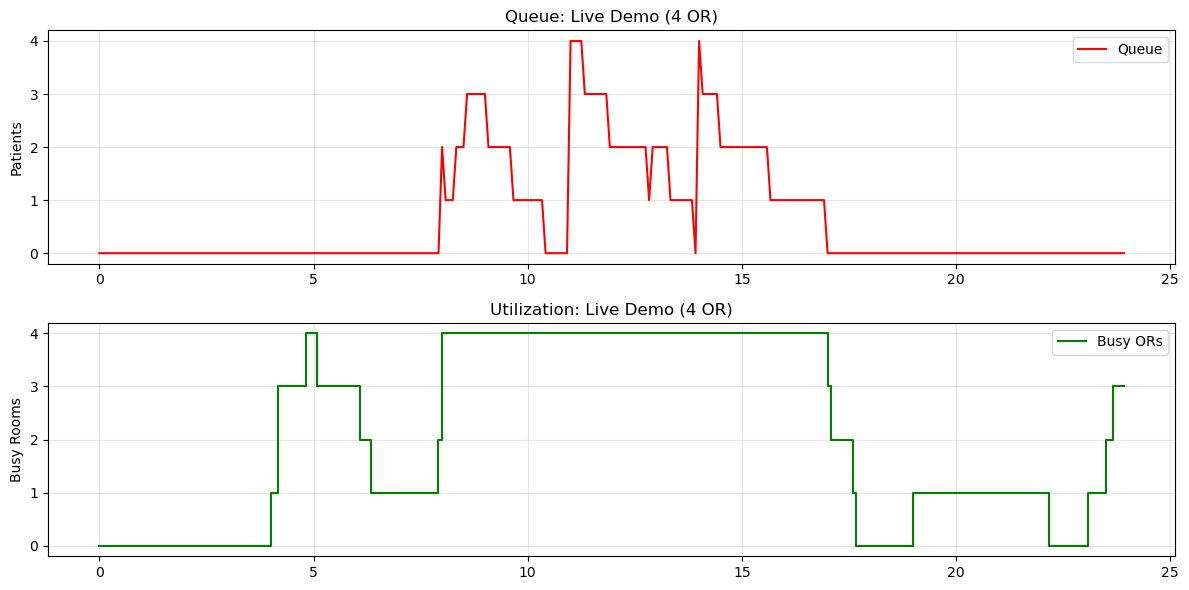


PLOTTING COMPARISON GRAPHS...


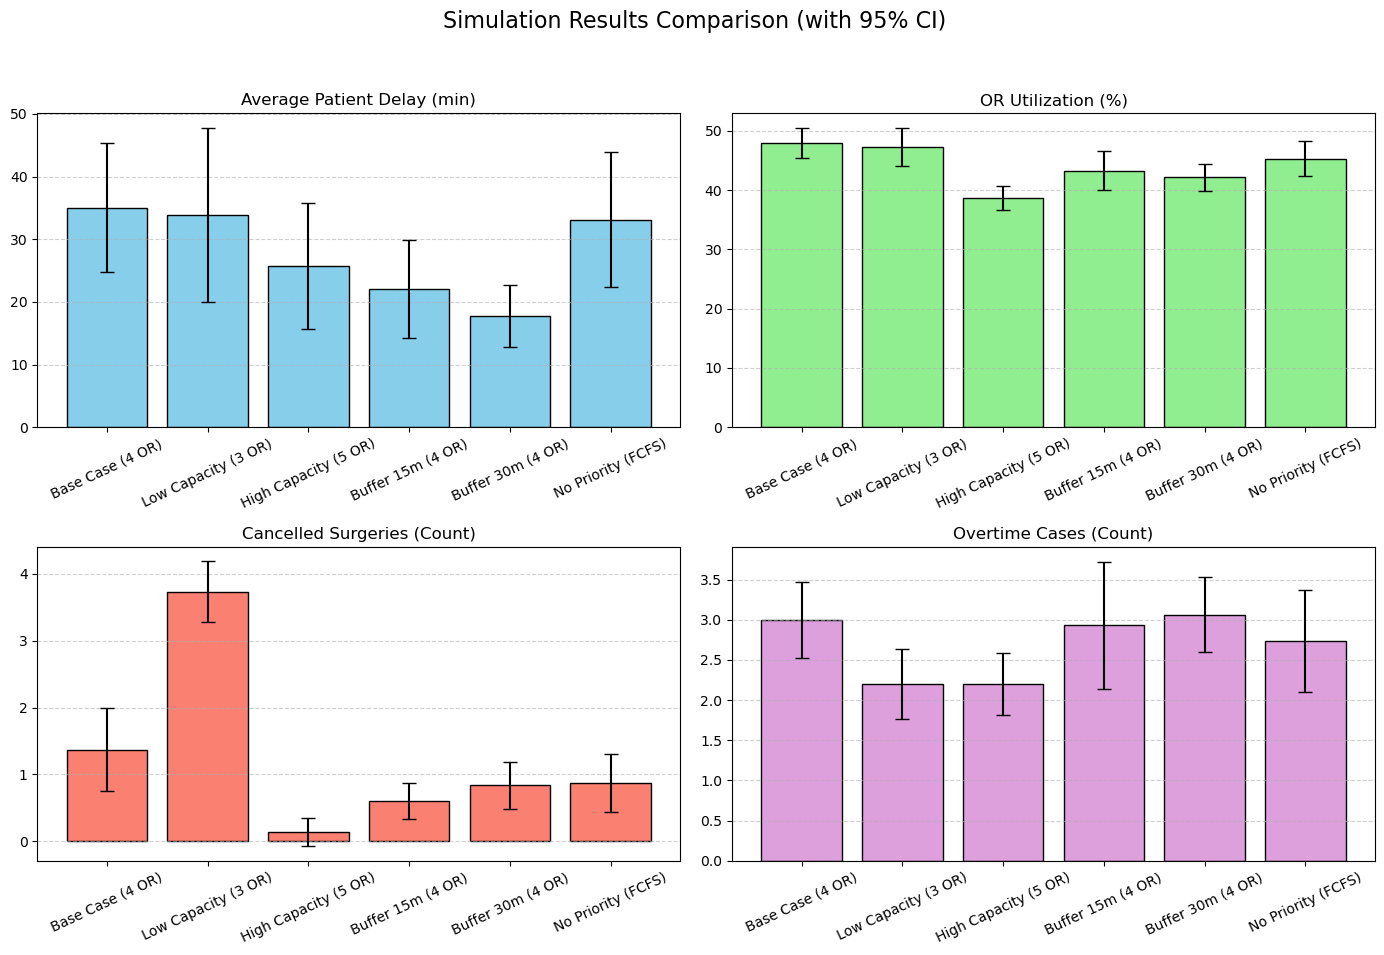

Analysis Complete.

DISPLAYING EVENT GRAPH MODEL...
Opening 'HospitalEventGraph.drawio.svg' directly in Notebook below:


In [27]:
# 7. MAIN EXECUTION

if __name__ == "__main__":

    # 1. RUN VISUAL DEMO
    # Now returns (DataFrame, MonitorData)
    gui_run_df, gui_monitor_data = run_experiment("Live Demo", 4, 0, 0, visualize=True)

    print("\n" + "=" * 60)
    print("VISUAL WINDOW CLOSED.")
    print("Starting Statistical Analysis Report (Please Wait)...")
    print("=" * 60 + "\n")

    # 2. RUN STATISTICAL SCENARIOS
    scenarios = [
        ("Base Case (4 OR)", 4, 0, 0),
        ("Low Capacity (3 OR)", 3, 0, 0),
        ("High Capacity (5 OR)", 5, 0, 0),
        ("Buffer 15m (4 OR)", 4, 15, 0),
        ("Buffer 30m (4 OR)", 4, 30, 0),
        ("No Priority (FCFS)", 4, 0, 1)
    ]

    final_report = []

    for sc_name, n_or, buff, em_prio in scenarios:
        res = run_experiment(sc_name, n_or, buff, em_prio, replications=30, visualize=False)
        final_report.append(res)

    # 3. PRINT OUTPUT REPORT (TABLES)
    print("\n" + "=" * 80)
    print("TABLE 1: PATIENT QUEUE & WAIT TIMES (Mean ± 95% CI)")
    print("=" * 80)
    table1_data = []
    for r in final_report:
        table1_data.append({
            'Scenario': r['Scenario'],
            'Avg Delay (min)': f"{r['Avg Delay']:.2f} ± {r['CI Delay']:.2f}",
            'Cancelled Cases': f"{r['Cancelled']:.2f} ± {r['CI Canc']:.2f}"
        })
    df_t1 = pd.DataFrame(table1_data)
    print(df_t1.to_string(index=False))

    print("\n\n" + "=" * 80)
    print("TABLE 2: OR UTILIZATION & OVERTIME (Mean ± 95% CI)")
    print("=" * 80)
    table2_data = []
    for r in final_report:
        table2_data.append({
            'Scenario': r['Scenario'],
            'OR Utilization (%)': f"{r['Utilization']:.2f} ± {r['CI Util']:.2f}",
            'Overtime Cases': f"{r['Overtime']:.2f} ± {r['CI Over']:.2f}"
        })
    df_t2 = pd.DataFrame(table2_data)
    print(df_t2.to_string(index=False))

    

    # 5. GENERATE CHARTS 
    print("\nGenerating Time-Series Charts for Live Demo...")
    generate_charts(gui_monitor_data, "Live Demo (4 OR)")

    # 6. PLOT COMPARISON GRAPHS
    print("\n" + "=" * 80)
    print("PLOTTING COMPARISON GRAPHS...")

    scenarios_list = [r['Scenario'] for r in final_report]
    means_delay = [r['Avg Delay'] for r in final_report]
    cis_delay = [r['CI Delay'] for r in final_report]
    means_util = [r['Utilization'] for r in final_report]
    cis_util = [r['CI Util'] for r in final_report]
    means_canc = [r['Cancelled'] for r in final_report]
    cis_canc = [r['CI Canc'] for r in final_report]
    means_over = [r['Overtime'] for r in final_report]
    cis_over = [r['CI Over'] for r in final_report]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Simulation Results Comparison (with 95% CI)', fontsize=16)

    axes[0, 0].bar(scenarios_list, means_delay, yerr=cis_delay, capsize=5, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Average Patient Delay (min)')
    axes[0, 0].tick_params(axis='x', rotation=25)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.6)

    axes[0, 1].bar(scenarios_list, means_util, yerr=cis_util, capsize=5, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('OR Utilization (%)')
    axes[0, 1].tick_params(axis='x', rotation=25)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.6)

    axes[1, 0].bar(scenarios_list, means_canc, yerr=cis_canc, capsize=5, color='salmon', edgecolor='black')
    axes[1, 0].set_title('Cancelled Surgeries (Count)')
    axes[1, 0].tick_params(axis='x', rotation=25)
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.6)

    axes[1, 1].bar(scenarios_list, means_over, yerr=cis_over, capsize=5, color='plum', edgecolor='black')
    axes[1, 1].set_title('Overtime Cases (Count)')
    axes[1, 1].tick_params(axis='x', rotation=25)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("Analysis Complete.")


